In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [23]:
# nifty50_stocks = [
#     "RELIANCE.NS" , "TCS.NS", "HDFCBANK.NS",  # ... Add other stock symbols here
#     # List of all NIFTY50 stocks: https://www1.nseindia.com/live_market/dynaContent/live_watch/equities_stock_watch.htm
# ]

start_date = "2010-01-01"
end_date = "2018-12-31"

stock_data = pd.DataFrame()

# download LNT stock price data
stock_data = yf.download("LT.NS", start=start_date, end=end_date)
stock_data.to_csv('lnt_stock_data.csv', index=False)

# download RELIANCE stock price data

# stock_data = yf.download("RELIANCE.NS", start=start_date, end=end_date)
# stock_data.to_csv('reliance_stock_data.csv', index=False)

print("Data collection and saving complete.")

[*********************100%%**********************]  1 of 1 completed
Data collection and saving complete.


In [38]:
# Read the data from the csv file, read only the column named Close
stock_data = pd.read_csv("lnt_stock_data.csv")[["Close"]]
stock_data.head()

,Close
0,751.733337
1,753.066650
2,744.733337
3,741.155579
4,745.844421


In [39]:
stock_data.describe()

,Close
count,2218.000000
mean,901.464703
std,248.912473
min,434.533325
25%,693.183350
50%,869.311127
75%,1113.549988
max,1455.599976


In [40]:
# Divide into 90% training and 10% testing
training_stock_data = stock_data[:int(len(stock_data)*0.9)].values
testing_stock_data = stock_data[int(len(stock_data)*0.9):].values

len(training_stock_data), len(testing_stock_data)

(1996, 222)

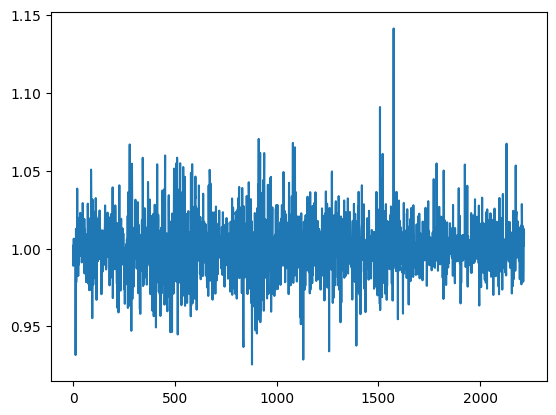

In [41]:
x = stock_data.values
plt.plot(x[1:] / x[:-1])

Clearly this shows, the stock value has an upward ascent<br>
Hence, we cannot have states as sections in range of training data's stock values as when it comes to testing, it will see newer values again.
Its better to work on the difference, or log ratios of consecutive occurences.<br>
<ul>
<li>Method 1: Differential States</li>
<li>Method 2: Log Returns</li>
</ul>


In [42]:
ratio_training_stock_data = training_stock_data[1:]/ training_stock_data[:-1]
len(ratio_training_stock_data)

1995

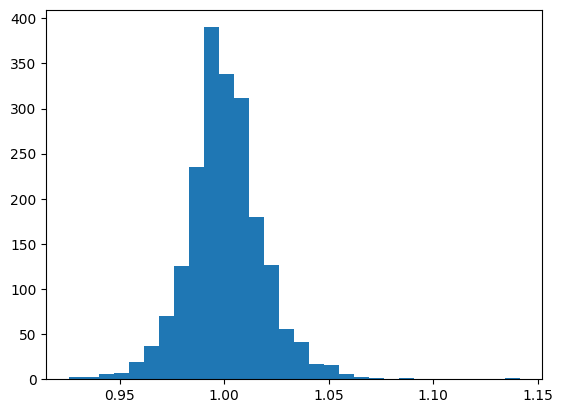

In [43]:
# Plot histogram of differential_training_stock_data
plt.hist(ratio_training_stock_data, bins=30)
plt.show()

In [44]:
# Print the bins for histogram of a data
hist, bins = np.histogram(ratio_training_stock_data, bins=30)
# Print the histogram plot
print(bins)

[0.92556471 0.9327571  0.93994949 0.94714187 0.95433426 0.96152665
 0.96871904 0.97591143 0.98310381 0.9902962  0.99748859 1.00468098
 1.01187336 1.01906575 1.02625814 1.03345053 1.04064292 1.0478353
 1.05502769 1.06222008 1.06941247 1.07660485 1.08379724 1.09098963
 1.09818202 1.10537441 1.11256679 1.11975918 1.12695157 1.13414396
 1.14133634]


In [45]:
ratio_testing_stock_data = testing_stock_data[1:] / testing_stock_data[:-1]
len(ratio_testing_stock_data), min(ratio_testing_stock_data), max(ratio_testing_stock_data)

(221, array([0.96340391]), array([1.06737082]))

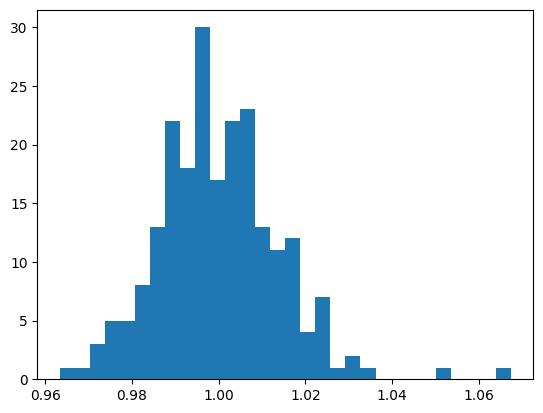

In [46]:
plt.hist(ratio_testing_stock_data, bins=30)
plt.show()

### Q Learning Temporal Difference Agent

In [136]:
from tqdm import tqdm

class Q_Learning_Agent:
    def __init__(self, bins, principal = 1000000, num_iterations=200, checkpoint=10):

        self.num_iterations = num_iterations
        self.checkpoint = checkpoint

        # Values below are hyperparameters
        # These are the values that we will tune to get the best results
        self.epsilon = 0.8
        self.decay = 1
        self.gamma = 0.95
        self.alpha = 0.9

        # Values below are the environment values
        self.max_lots_tradable = 36
        self.lot_size = 15
        self.transaction_cost = 0.000007
        self.holdings = 0
        self.avg_value = 0

        self.bins = bins        

        # Values below are the state and action spaces and the q-table
        self.action_space = [i for i in range(-self.max_lots_tradable, self.max_lots_tradable+1)]
        self.q_table = np.zeros((len(self.bins)+1, len(self.action_space)))

        # Values below are the current state of the agent
        self.cumulative_reward = 0
        self.money = principal
        self.principal = principal
    
    def map_diff_2_statespace(self, diff):
        return np.digitize(x=diff, bins=self.bins)[0]
    
    # Epsilon Greedy Approach ==> (Can we do better? Thomson Sampling? or UCB?)
    def get_action(self, current_val, prev_val):
        if np.random.uniform(0,1) <= self.epsilon:
            # Exploration
            action = np.random.choice(self.action_space)
            # self.epsilon = self.epsilon * self.decay
            # assert(action in self.action_space)
            return action
        else:
            current_state = self.map_diff_2_statespace(current_val/prev_val)
            action = np.argmax(self.q_table[current_state]) - self.max_lots_tradable
            # assert(action in self.action_space)
            return action
    
    def get_reward(self, current_val, action):
        earlier_money = self.money

        if(action > 0):
            if(self.holdings >= 0): 
                self.money = self.money - action*self.lot_size*current_val - abs(action)*self.lot_size*self.transaction_cost*current_val
                self.avg_value = (self.avg_value*self.holdings + action*current_val)/(self.holdings + action)
            else:
                if(abs(action) <= abs(self.holdings)):
                    self.money = self.money + action*self.lot_size*(2*self.avg_value  - current_val) - abs(action)*self.lot_size*self.transaction_cost*current_val
                else:
                    self.money = self.money + (2*abs(self.holdings)-current_val)*self.lot_size*self.avg_value + (-abs(self.holdings)+action)*self.lot_size*current_val - abs(action)*self.lot_size*self.transaction_cost*current_val
                    self.avg_value = current_val
        elif(action < 0):
            if(self.holdings <= 0):
                self.money = self.money - abs(action)*self.lot_size*current_val - abs(action)*self.lot_size*self.transaction_cost*current_val
                self.avg = abs((self.avg_value*self.holdings + action*current_val)/(self.holdings + action))
            else:
                if(abs(action) <= self.holdings):
                    self.money = self.money + abs(action)*self.lot_size*current_val - abs(action)*self.lot_size*self.transaction_cost*current_val
                else:
                    self.money = self.money + (2*self.holdings - abs(action))*self.lot_size*current_val - abs(action)*self.lot_size*self.transaction_cost*current_val
                    self.avg_value = current_val

        if(self.money < 0):
            self.money = earlier_money
            return None
        self.holdings += action
        reward = self.money - earlier_money
        return reward
    
    # GREEDY APPROACH => UNSTABLE LEARNING OR 
    # Maybe Use RL-LSTM (NIPS Paper, Literature Review)
    # def predict_next_state(self):
    #     return np.argmax(self.q_table[self.current_state])

    def update_q_table(self, prev_val, current_val, action, next_val):
        current_state = self.map_diff_2_statespace(current_val/prev_val)
        next_state = self.map_diff_2_statespace(next_val/current_val)
        reward = self.get_reward(current_val, action)
        if(reward == None):
            return # soi 
        self.cumulative_reward += reward
        q_new = reward + self.gamma*np.max(self.q_table[next_state])
        self.q_table[current_state][action+self.max_lots_tradable] = (1-self.alpha)*self.q_table[current_state][action+self.max_lots_tradable] + self.alpha*q_new
    
    def train(self, data):
        cumulative_rewards = []
        for i in range(self.num_iterations):
            self.epsilon = self.epsilon * self.decay
            for j in range(1,len(data)-1):
                action = self.get_action(data[j], data[j-1])
                # If beyond aukat, then null and void)
                if(action>0 and self.holdings>0 or action < 0 and self.holdings<0):
                    if(abs(action*self.lot_size*data[j]) > self.money): 
                        continue
                
                self.update_q_table(data[j-1], data[j], action, data[j+1])
            

            if (i+1)%self.checkpoint == 0:
                print("Iteration:", i+1, " Cumulative Reward:", self.cumulative_reward)
            
            if(self.holdings>=0):
                self.cumulative_reward += (abs(self.holdings)*self.lot_size*data[-1] - abs(self.holdings)*self.lot_size*self.transaction_cost*data[-1]) 
            else:
                self.cumulative_reward += (abs(self.holdings)*self.lot_size*(2*self.avg_value - data[-1]) - abs(self.holdings)*self.lot_size*self.transaction_cost*data[-1])
            cumulative_rewards.append(self.cumulative_reward)
            self.cumulative_reward = 0
            self.money = self.principal
        return cumulative_rewards

    def plot_progress(self, cumulative_rewards):
        plt.plot(cumulative_rewards)
        plt.xlabel("Iterations")
        plt.ylabel("Cumulative Reward")
        plt.show()
    
    def save_q_table(self, filename):
        np.save(filename, self.q_table)
    
    def load_q_table(self, filename):
        self.q_table = np.load(filename)

Iteration: 50  Cumulative Reward: [-827164.93456657]
Iteration: 100  Cumulative Reward: [-463886.57984543]
Iteration: 150  Cumulative Reward: [-797471.12957221]
Iteration: 200  Cumulative Reward: [-411766.89039022]
Iteration: 250  Cumulative Reward: [-635143.43445169]
Iteration: 300  Cumulative Reward: [-596909.60355219]
Iteration: 350  Cumulative Reward: [-671188.43448571]
Iteration: 400  Cumulative Reward: [-792007.07747918]
Iteration: 450  Cumulative Reward: [428750.72388014]
Iteration: 500  Cumulative Reward: [-964051.6150104]
Iteration: 550  Cumulative Reward: [1193311.88448401]
Iteration: 600  Cumulative Reward: [-556034.99992778]
Iteration: 650  Cumulative Reward: [591474.1391167]
Iteration: 700  Cumulative Reward: [-20863.54202217]
Iteration: 750  Cumulative Reward: [-778727.78646421]
Iteration: 800  Cumulative Reward: [-913090.01168157]
Iteration: 850  Cumulative Reward: [-863558.22133298]
Iteration: 900  Cumulative Reward: [-608072.84747633]
Iteration: 950  Cumulative Reward:

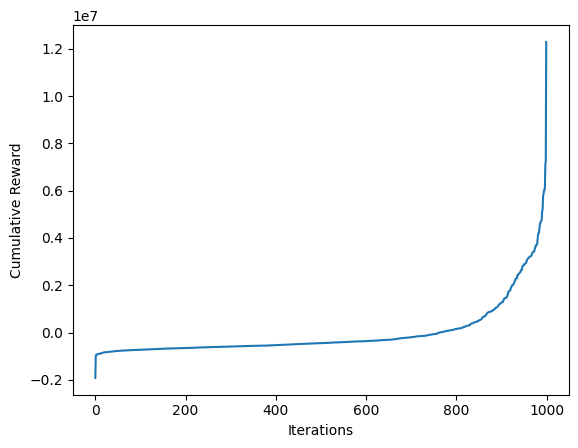

In [138]:
agent = Q_Learning_Agent(bins, principal = 1000000, num_iterations = 1000, checkpoint = 50)
cumulative_rewards = agent.train(training_stock_data)
cumulative_rewards.sort()
agent.plot_progress(cumulative_rewards)

In [139]:
agent.save_q_table("q_table")

In [148]:
def test(agent, data):
        agent.money = 1000000
        cumulative_reward = 0
        agent.epsilon = 0.9
        actions, rewards = [], []
        for val in tqdm(data):
            action = np.argmax(agent.q_table[agent.map_diff_2_statespace(val)])
            actions.append(action)
            reward = agent.get_reward(action, val)
            if reward:
                rewards.append(reward)
                cumulative_reward += reward
            else:
                rewards.append(0)
                cumulative_reward += 0

        return actions, rewards, cumulative_reward


In [149]:
actions, rewards, cumulative_reward = test(agent, testing_stock_data)
cumulative_reward

100%|██████████| 222/222 [00:00<00:00, 21248.13it/s]


array([206021.14581866])

c:\Users\sabya\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


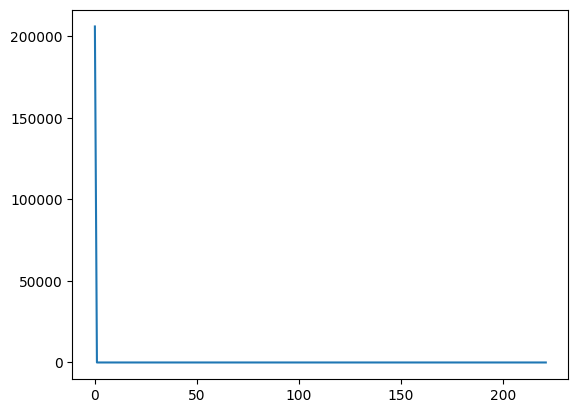

In [150]:
plt.plot(rewards)

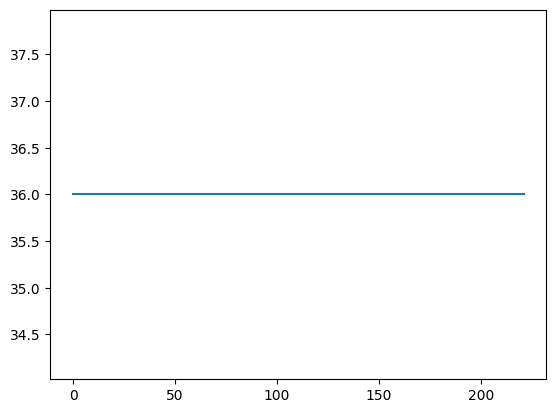

In [85]:
plt.plot(actions)